User 'user1' registered successfully.
Income added successfully.
Expense added successfully.
Expense added successfully.

Income:
Salary: $3000.0 on 2024-06-15
Salary: $3000.0 on 2024-06-15

Expenses:
Rent: $1000.0 (Housing) on 2024-06-15
Groceries: $300.0 (Food) on 2024-06-15
Rent: $1000.0 (Housing) on 2024-06-15
Groceries: $300.0 (Food) on 2024-06-15


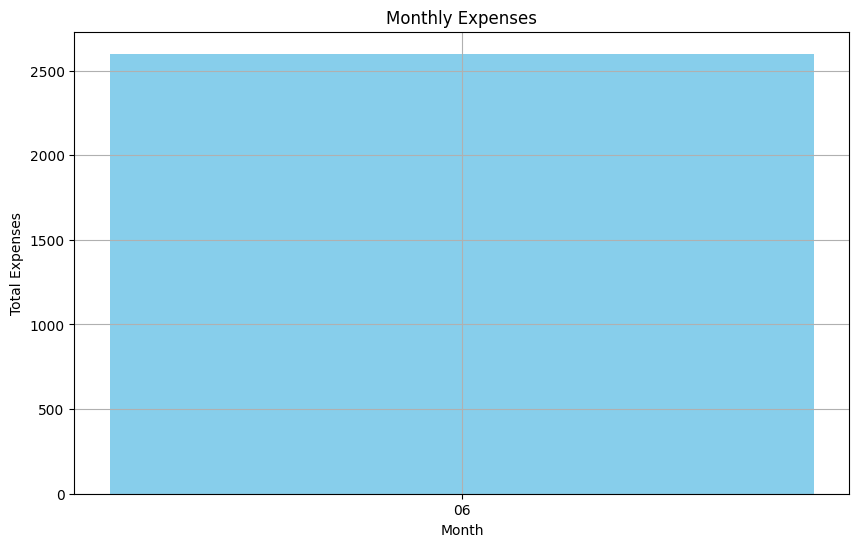

In [2]:
import sqlite3
from datetime import datetime
import matplotlib.pyplot as plt

# Initialize SQLite database
conn = sqlite3.connect('budget_manager.db')
c = conn.cursor()

# Create tables if they don't exist
c.execute('''CREATE TABLE IF NOT EXISTS users (
                user_id INTEGER PRIMARY KEY AUTOINCREMENT,
                username TEXT NOT NULL,
                password TEXT NOT NULL
            )''')

c.execute('''CREATE TABLE IF NOT EXISTS income (
                income_id INTEGER PRIMARY KEY AUTOINCREMENT,
                user_id INTEGER NOT NULL,
                description TEXT NOT NULL,
                amount REAL NOT NULL,
                date DATE NOT NULL,
                FOREIGN KEY (user_id) REFERENCES users(user_id)
            )''')

c.execute('''CREATE TABLE IF NOT EXISTS expenses (
                expense_id INTEGER PRIMARY KEY AUTOINCREMENT,
                user_id INTEGER NOT NULL,
                description TEXT NOT NULL,
                amount REAL NOT NULL,
                category TEXT NOT NULL,
                date DATE NOT NULL,
                FOREIGN KEY (user_id) REFERENCES users(user_id)
            )''')

conn.commit()

# Function to register a new user
def register_user(username, password):
    try:
        c.execute('INSERT INTO users (username, password) VALUES (?, ?)', (username, password))
        conn.commit()
        print(f"User '{username}' registered successfully.")
    except sqlite3.Error as e:
        print(f"Error registering user: {e}")

# Function to authenticate user login
def login_user(username, password):
    c.execute('SELECT * FROM users WHERE username=? AND password=?', (username, password))
    user = c.fetchone()
    if user:
        return user[0]  # Return user_id if login successful
    else:
        return None

# Function to add income
def add_income(user_id, description, amount):
    try:
        date = datetime.now().date()
        c.execute('INSERT INTO income (user_id, description, amount, date) VALUES (?, ?, ?, ?)',
                  (user_id, description, amount, date))
        conn.commit()
        print("Income added successfully.")
    except sqlite3.Error as e:
        print(f"Error adding income: {e}")

# Function to add expense
def add_expense(user_id, description, amount, category):
    try:
        date = datetime.now().date()
        c.execute('INSERT INTO expenses (user_id, description, amount, category, date) VALUES (?, ?, ?, ?, ?)',
                  (user_id, description, amount, category, date))
        conn.commit()
        print("Expense added successfully.")
    except sqlite3.Error as e:
        print(f"Error adding expense: {e}")

# Function to display income and expenses for a user
def display_budget(user_id):
    try:
        c.execute('SELECT * FROM income WHERE user_id=?', (user_id,))
        incomes = c.fetchall()
        print("\nIncome:")
        for income in incomes:
            print(f"{income[2]}: ${income[3]} on {income[4]}")

        c.execute('SELECT * FROM expenses WHERE user_id=?', (user_id,))
        expenses = c.fetchall()
        print("\nExpenses:")
        for expense in expenses:
            print(f"{expense[2]}: ${expense[3]} ({expense[4]}) on {expense[5]}")
    except sqlite3.Error as e:
        print(f"Error fetching data: {e}")

# Function to plot monthly expenses
def plot_monthly_expenses(user_id):
    try:
        c.execute('''SELECT strftime('%m', date) AS month, SUM(amount) AS total_expense
                     FROM expenses
                     WHERE user_id=?
                     GROUP BY strftime('%m', date)
                     ORDER BY strftime('%m', date)''', (user_id,))
        data = c.fetchall()

        months = [row[0] for row in data]
        expenses = [row[1] for row in data]

        plt.figure(figsize=(10, 6))
        plt.bar(months, expenses, color='skyblue')
        plt.xlabel('Month')
        plt.ylabel('Total Expenses')
        plt.title('Monthly Expenses')
        plt.xticks(months)
        plt.grid(True)
        plt.show()
    except sqlite3.Error as e:
        print(f"Error plotting monthly expenses: {e}")

# Sample usage:
if __name__ == '__main__':
    # Register and login users
    register_user('user1', 'password1')
    user_id = login_user('user1', 'password1')

    if user_id:
        # Add income and expenses
        add_income(user_id, 'Salary', 3000.00)
        add_expense(user_id, 'Rent', 1000.00, 'Housing')
        add_expense(user_id, 'Groceries', 300.00, 'Food')

        # Display budget details
        display_budget(user_id)

        # Plot monthly expenses (if Matplotlib is installed)
        try:
            plot_monthly_expenses(user_id)
        except NameError:
            print("Matplotlib is not installed. Skipping plot.")

    conn.close()
